In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import glob
import imageio
import PIL
from IPython import display
%load_ext tensorboard

## Import and preprocess the Data 

## Data import

In [ ]:
#load quickdraw data 
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
category = 'candle'

In [ ]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images in total')

# get 80% of all image length for training dataset
train_len = int(0.8 * len(images))
test_len = len(images) - train_len
print(f'{train_len} images to train on')
print(f'{test_len} images to test on')
# You can limit the amount of images you use for training by setting (80%):
train_ds = tf.data.Dataset.from_tensor_slices(images[:train_len])
# You should also define a samller subset of the images for testing (20%)
val_ds = tf.data.Dataset.from_tensor_slices(images[train_len:])


# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images in total
113236 images to train on
28309 images to test on


## Data preprocessing

### Data pipeline

In [ ]:
# Preproces the data using the map method or scan
def preprocess(data, batch_size, noise_rate=0.4):
  #data = data.map(lambda x, t: (tf.expand_dims(x, axis=-1)))
  data = data.map(lambda x: (tf.cast(x, float)))
  data = data.map(lambda x: (x/255.))
  data = data.map(lambda x: (tf.reshape(x, [28,28,1])))
  ds = data.shuffle(1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

train_ds = preprocess(train_ds, batch_size=32)
val_ds = preprocess(val_ds, batch_size=32)

# The model classes

## The Discriminator

In [ ]:
class Discriminator(tf.keras.Model):
  
  #1 Constructor
  def __init__(self):
    super(Discriminator, self).__init__()
    #inherit functionality from parent class

    #list of layers of the network
    self.layers_list = [
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28,28,1)),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(1)
    ]

  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)

    return x

## The Generator

In [ ]:
class Generator(tf.keras.Model):
  
  #1 Constructor
  def __init__(self):
    super(Generator, self).__init__()
    #inherit functionality from parent class

    #list of the layers of the network
    self.layers_list = [
        tf.keras.layers.Dense(7*7*256, activation='relu', input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Reshape((7,7,256)),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')
    ]


  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)

    return x

    

## The GAN

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
class GAN(tf.keras.Model):
  
    #1 Constructor
    def __init__(self, batch_size):
        super(GAN, self).__init__()
        #inherit functionality from parent class

        #Regresion => MeanSquaredError, Adam Optimiser
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

        self.metrics_list = [
                            tf.keras.metrics.MeanSquaredError(name="loss"),
                            tf.keras.metrics.Accuracy(name="acc")
                           ]

        self.generator = Generator()
        self.discriminator = Discriminator()
        self.batch_size = batch_size

    #2. call method (forward computation)
    def call(self, data, training=False):
        return self.generator(data)

    #5 training step method
    def train_step(self, img):
        # create 1Dnoise vector with shape of latent space = 100
        noise = tf.random.normal([self.batch_size, 100])

        # calc loss for discriminator on how correctly fake and real images are detected
        # calc generator loss
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # create images from noise with generator
            generated_images = self.generator(noise, training=True)

            # feed discriminator with batch of fake and batch of real images
            real_output = self.discriminator(img, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # return a dictionary with metric names as keys and metric results as values
        return (generated_images[:10], img[:10])
    

    #6. test step method
    def test_step(self, noise):
        generated_images = self.generator(noise, training=False)
        fig = plt.figure(figsize=(4, 4))

        return generated_images


    

# Summary writer

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_path = f"logs/train/"
val_log_path = f"logs/val/"
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path + current_time)
# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path + current_time)

# Training loop

In [ ]:
import tqdm
def training_loop(model, train_ds, val_ds, epochs, batch_size, train_summary_writer, val_summary_writer, save_path):

  #define test noise vector
  val_noise = tf.random.normal([batch_size, 100])

  #1. iterate over epochs
  for e in range(epochs):
    #2. train steps on all batchs in the training data
    for data in tqdm.tqdm(train_ds):
      ret = model.train_step(data)

    #5. evaluate on validation data
    test_output = model.test_step(val_noise)
    for i in range(out.shape[0]):
      plt.subplot(4, 8, i+1)
      plt.imshow(out[i, :, :, 0])
      plt.axis('off')
    plt.show()


  #8 save model weights
  model.save_weightws(save_path)
  return test_output

# Model training

100%|██████████| 3539/3539 [29:15<00:00,  2.02it/s]


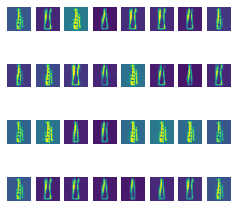

100%|██████████| 3539/3539 [28:24<00:00,  2.08it/s]


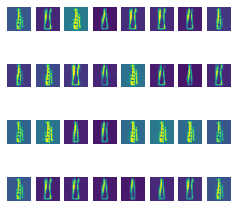

100%|██████████| 3539/3539 [28:21<00:00,  2.08it/s]


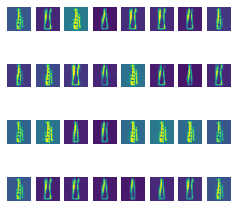

 14%|█▍        | 489/3539 [03:56<24:21,  2.09it/s]

In [ ]:
#1. instantiate model
batch_size = 32wwwwwwwwwwwwwwwwwwwwwww
model = GAN(batch_size=32)
epochs=10

#2. choose a path to save the weights
save_path = "trained_model"

out = training_loop(model, train_ds,val_ds, epochs, batch_size, train_summary_writer, val_summary_writer, save_path)

In [ ]:
out.shape

TensorShape([32, 28, 28, 1])

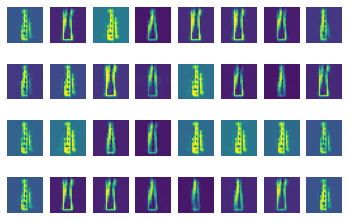

In [ ]:
#TODO: metrics
for i in range(out.shape[0]):
  plt.subplot(4, 8, i+1)
  plt.imshow(out[i, :, :, 0])
  plt.axis('off')
plt.show()
